In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



In [3]:
# 2. LOAD DATA
movies = pd.read_csv("movies.csv")
actors = pd.read_csv("actors.csv")
movie_to_actor = pd.read_csv("movie_to_actor_character.csv")

print(f"Movies: {len(movies)}, Actors: {len(actors)}, Links: {len(movie_to_actor)}")



Movies: 11573, Actors: 40151, Links: 36242


In [4]:
# 3. BUILD SIMPLE TEXT FEATURES (genres + synopsis)
movies["features"] = movies["genres"].fillna("") + " " + movies["synopsis"].fillna("")
movies["features"] = movies["features"].str.strip()
movies = movies[movies["features"].str.len() > 0].reset_index(drop=True)

print(f"Movies with non-empty features: {len(movies)}")



Movies with non-empty features: 11573


In [5]:
# 4. TF-IDF VECTORIZATION
tfidf = TfidfVectorizer(
    max_features=100,
    stop_words="english",
    min_df=2
)
tfidf_matrix = tfidf.fit_transform(movies["features"])
print("TF-IDF matrix shape:", tfidf_matrix.shape)



TF-IDF matrix shape: (11573, 100)


In [20]:
# 5. K-MEANS CLUSTERING 
K = 5
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(tfidf_matrix)
movies["cluster"] = cluster_labels

print("Cluster sizes:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(cluster_counts)





Cluster sizes:
0    4553
1    2660
2    1725
3    1427
4    1208
Name: count, dtype: int64


In [21]:
# 6. COSINE SIMILARITY
cosine_sim = cosine_similarity(tfidf_matrix)
print("Cosine similarity matrix shape:", cosine_sim.shape)

# ---- HEATMAP OF COSINE SIMILARITY (SAMPLE) ----
# Take a small sample of movies (e.g., first 20) to keep heatmap readable
sample_size = 20
cosine_sample = cosine_sim[:sample_size, :sample_size]



Cosine similarity matrix shape: (11573, 11573)


In [8]:
# 7. RECOMMENDATION FUNCTION
def recommend_movies(movie_title, n_recommendations=5):
    """
    Recommend similar movies using TF-IDF + cosine similarity.
    """
    match = movies[movies["title"].str.lower() == movie_title.lower()]
    if match.empty:
        return f"Movie '{movie_title}' not found in database."
    
    idx = match.index[0]
    sim_scores = cosine_sim[idx]
    similar_indices = np.argsort(sim_scores)[::-1][1:n_recommendations+1]
    
    result = movies.iloc[similar_indices][["title", "year", "genres", "cluster"]].copy()
    result["similarity"] = sim_scores[similar_indices]
    return result



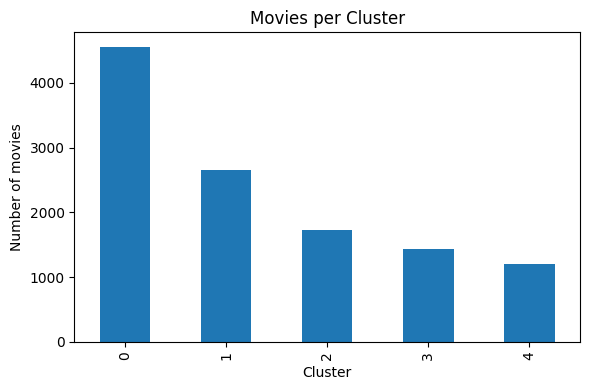

In [22]:
# 8. BASIC VISUALISATIONS (same level as lecture EDA)

# 8.1 Cluster sizes bar chart
plt.figure(figsize=(6, 4))
movies["cluster"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Cluster")
plt.ylabel("Number of movies")
plt.title("Movies per Cluster")
plt.tight_layout()
plt.show()

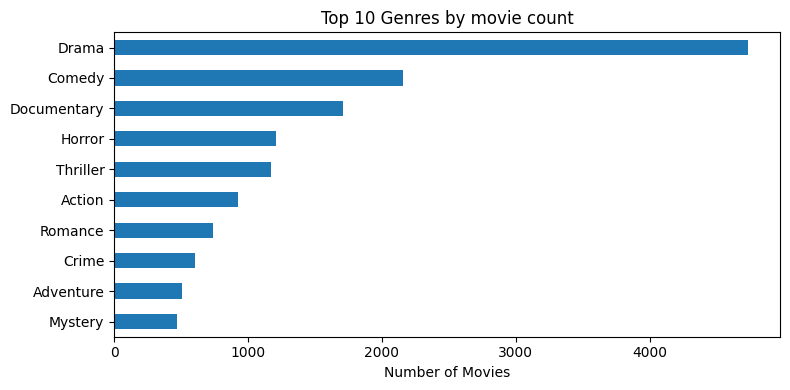

In [34]:
# 8.2 Top 10 genres bar chart
from collections import Counter
all_genres = []
for g in movies["genres"].dropna():
    all_genres.extend([x.strip() for x in g.split(",")])

genre_counts = Counter(all_genres)
top_genres = pd.Series(dict(genre_counts.most_common(10)))

plt.figure(figsize=(8, 4))
top_genres.sort_values().plot(kind="barh")
plt.xlabel("Number of Movies")
plt.title("Top 10 Genres by movie count")
plt.tight_layout()
plt.show()

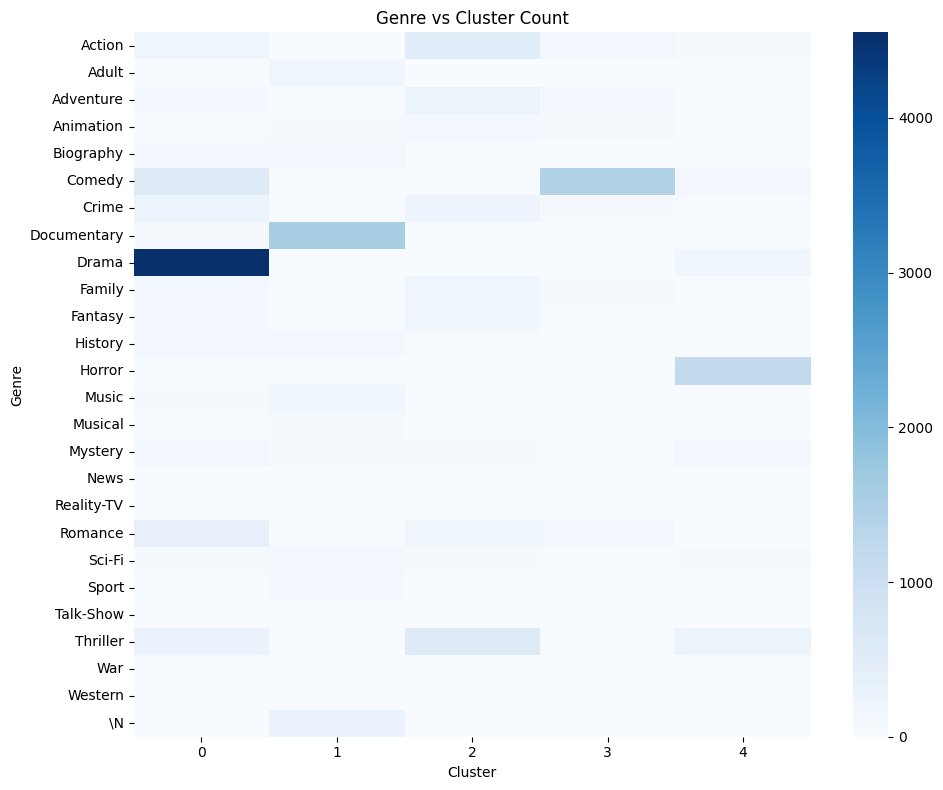

In [28]:
# 8.3 Cluster vs genre heatmap
rows = []
for _, row in movies[['genres', 'cluster']].dropna().iterrows():
    for g in row['genres'].split(','):
        rows.append({'genre': g.strip(), 'cluster': row['cluster']})
genre_cluster = pd.DataFrame(rows)
pivot_gc = pd.crosstab(genre_cluster['genre'], genre_cluster['cluster'])

plt.figure(figsize=(10,8))
sns.heatmap(pivot_gc, cmap="Blues")
plt.title("Genre vs Cluster Count")
plt.xlabel("Cluster")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

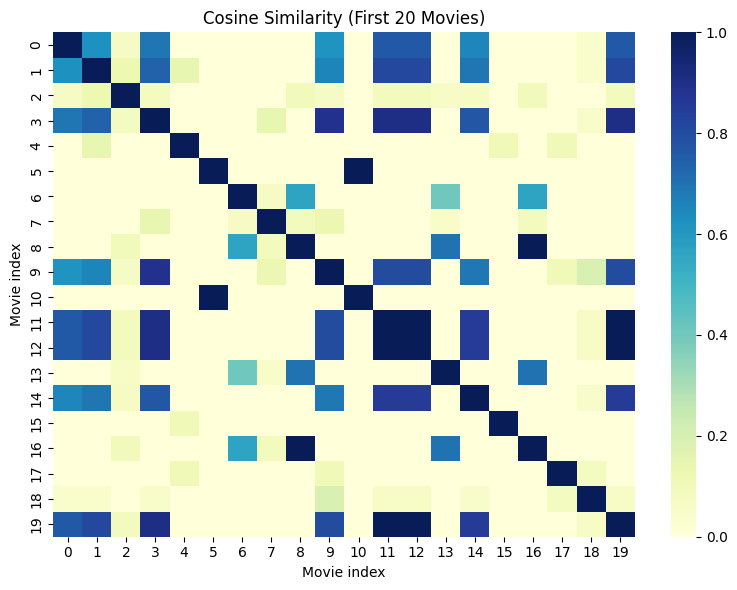

In [42]:
# 8.4 Cosine similarity heatmap (subset of movies)
sample_size = 20  # first 20 movies
cosine_sample = cosine_sim[:sample_size, :sample_size]


plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sample, cmap="YlGnBu")
plt.title("Cosine Similarity (First 20 Movies)")
plt.xlabel("Movie index")
plt.ylabel("Movie index")
plt.tight_layout()
plt.show()

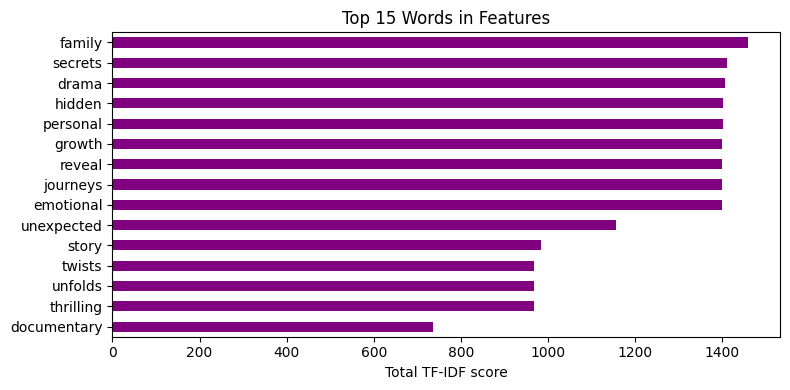

In [31]:
# 8.5 Top 15 TF-IDF words (bar chart)
feature_names = tfidf.get_feature_names_out()
word_sums = np.asarray(tfidf_matrix.sum(axis=0)).ravel()
top_word_idx = word_sums.argsort()[::-1][:15]
top_words = pd.Series(word_sums[top_word_idx], index=feature_names[top_word_idx])

plt.figure(figsize=(8, 4))
top_words.sort_values().plot(kind="barh", color="purple")
plt.xlabel("Total TF-IDF score")
plt.title("Top 15 Words in Features")
plt.tight_layout()
plt.show()

In [32]:
# 9. SIMPLE CLUSTER INSPECTION
from collections import Counter

for c in range(K):
    cluster_movies = movies[movies["cluster"] == c]
    print(f"\n=== Cluster {c} ({len(cluster_movies)} movies) ===")
    all_genres = []
    for g in cluster_movies["genres"].dropna():
        all_genres.extend([x.strip() for x in g.split(",")])
    if all_genres:
        top_genres = Counter(all_genres).most_common(3)
        print("Top genres:", ", ".join([g for g, _ in top_genres]))
    print("Sample titles:", ", ".join(cluster_movies["title"].head(3).tolist()))





=== Cluster 0 (4553 movies) ===
Top genres: Drama, Comedy, Romance
Sample titles: Neither Hero Nor Traitor, Madison, Party Hard

=== Cluster 1 (2660 movies) ===
Top genres: Documentary, \N, Adult
Sample titles: Bring 'em Black, This Is Not Normal, Built Beautiful: An Architecture and Neuroscience Love Story with Narration by Martha Stewart

=== Cluster 2 (1725 movies) ===
Top genres: Thriller, Action, Adventure
Sample titles: Disordered, Kaiji: Final Game, Stick Monster Movie

=== Cluster 3 (1427 movies) ===
Top genres: Comedy, Romance, Action
Sample titles: Figli, The Industry Did It, Ian Cranstons Book of Legends

=== Cluster 4 (1208 movies) ===
Top genres: Horror, Thriller, Drama
Sample titles: The Demon of Daingerfield, Hotline, Alone with Bigfoot


In [35]:
# 10. TEST RECOMMENDATIONS
example_title = movies["title"].iloc[0]
print(f"\nExample recommendations for: {example_title}")
print(recommend_movies(example_title, 5))



Example recommendations for: Neither Hero Nor Traitor
                                title  year         genres  cluster  \
10562  Clouds of Death - Bolimov 1915  2020  Drama,History        0   
6767               La Lupa (La Louve)  2020  Drama,History        0   
0            Neither Hero Nor Traitor  2020  Drama,History        0   
6754                      Manor House  2020  Drama,History        0   
1652                Efunsetan Aniwura  2020  Drama,History        0   

       similarity  
10562         1.0  
6767          1.0  
0             1.0  
6754          1.0  
1652          1.0  


In [36]:

# 11. INTERACTIVE RECOMMENDER
print("\n================ INTERACTIVE RECOMMENDER ================")
print("Type a movie title to get similar movies.")
print("Type 'quit' to stop.\n")

while True:
    user_title = input("Enter a movie title: ").strip()
    if user_title.lower() in ["quit", "exit", "q"]:
        print("Exiting recommender. Goodbye!")
        break
    
    result = recommend_movies(user_title, 5)
    print()
    if isinstance(result, str):
        print(result)
    else:
        print(f"Top 5 recommendations for: {user_title}")
        display(result[["title", "year", "genres", "cluster", "similarity"]])
    print()



================ INTERACTIVE RECOMMENDER ================
Type a movie title to get similar movies.
Type 'quit' to stop.


Top 5 recommendations for: Madison


,title,year,genres,cluster,similarity
1,Madison,2020,"Adventure,Drama,Family",0,1.0
4933,Silver Skates,2020,"Adventure,Drama,Family",0,1.0
5477,The Legend of the Five,2020,"Adventure,Drama,Family",0,1.0
4410,The Crossing,2020,"Adventure,Drama,Family",0,1.0
5041,All I Want for Christmas 2,2020,"Adventure,Drama,Family",0,1.0



Exiting recommender. Goodbye!
